In [1]:
!pip install lightgbm optuna


# Data Loading and Cleaning

In [2]:
import pandas as pd
import numpy as np
import japanize_matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import optuna

input_file = "../data/sales_data.csv"
df = pd.read_csv(input_file)

df['Sales'] = pd.to_numeric(df['Sales'].str.replace(',', ''), errors='coerce').fillna(0).astype('int64')
df['Digital_Ads'] = pd.to_numeric(df['Digital_Ads'].astype(str).str.replace(',', ''), errors='coerce').fillna(0).astype('int64')
df['Offline_Ads'] = pd.to_numeric(df['Offline_Ads'].astype(str).str.replace(',', ''), errors='coerce').fillna(0).astype('int64')
df['TVCM_GPR'] = pd.to_numeric(df['TVCM_GPR'].astype(str).str.replace(',', ''), errors='coerce').fillna(0)
df['Print_Media'] = pd.to_numeric(df['Print_Media'].astype(str).str.replace(',', ''), errors='coerce').fillna(0)

df['Date'] = pd.to_datetime(df['Date'])

print("Data loaded and cleaned. First 5 rows:")
display(df.head(5))

Data loaded and cleaned. First 5 rows:


/var/folders/_n/cr9xqtgn70g_tclcyk9hd0nw0000gn/T/ipykernel_49663/1394044037.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


,Date,Sales,TVCM_GPR,Print_Media,Offline_Ads,Digital_Ads,Record_Type
0,2015-09-07,5554981,58.86750,20340000,5890000,23080,Actual
1,2015-09-14,6071669,235.18125,15470000,5740000,29979,Actual
2,2015-09-21,5798657,252.18375,8325000,0,23784,Actual
3,2015-09-28,6235157,75.25500,0,0,26732,Actual
4,2015-10-05,6861105,0.00000,0,0,28823,Actual


# Create Monthly Dummies

In [3]:
def count_days_in_week(start_date):
    counts = {f'{i}月': 0 for i in range(1, 13)}
    for i in range(7):
        day = start_date + pd.Timedelta(days=i)
        month_str = f'{day.month}月'
        counts[month_str] += 1
    return pd.Series(counts)

monthly_cols = [f'{i}月' for i in range(1, 13)]
if not all(c in df.columns for c in monthly_cols):
    month_dummy_df = df['Date'].apply(count_days_in_week)
    df = pd.concat([df, month_dummy_df], axis=1)
    print("Monthly dummies created.")
else:
    print("Monthly dummies already exist, skipping creation.")

display(df.head(5))

Monthly dummies created.


,Date,Sales,TVCM_GPR,Print_Media,Offline_Ads,Digital_Ads,Record_Type,1月,2月,3月,4月,5月,6月,7月,8月,9月,10月,11月,12月
0,2015-09-07,5554981,58.86750,20340000,5890000,23080,Actual,0,0,0,0,0,0,0,0,7,0,0,0
1,2015-09-14,6071669,235.18125,15470000,5740000,29979,Actual,0,0,0,0,0,0,0,0,7,0,0,0
2,2015-09-21,5798657,252.18375,8325000,0,23784,Actual,0,0,0,0,0,0,0,0,7,0,0,0
3,2015-09-28,6235157,75.25500,0,0,26732,Actual,0,0,0,0,0,0,0,0,3,4,0,0
4,2015-10-05,6861105,0.00000,0,0,28823,Actual,0,0,0,0,0,0,0,0,0,7,0,0


# Create Holiday Dummies

In [4]:
from datetime import datetime

holiday_ranges = {
    '正月': [
        (datetime(2015,12,28), datetime(2016,1,3)),
        (datetime(2016,12,26), datetime(2017,1,3)),
        (datetime(2017,12,25), datetime(2018,1,3)),
    ],
    'GW': [
        (datetime(2015,4,29), datetime(2015,5,5)),
        (datetime(2016,4,29), datetime(2016,5,5)),
        (datetime(2017,4,29), datetime(2017,5,5)),
    ],
    'お盆': [
        (datetime(2015,8,13), datetime(2015,8,16)),
        (datetime(2016,8,13), datetime(2016,8,16)),
        (datetime(2017,8,13), datetime(2017,8,16)),
    ]
}

df['正月'] = 0
df['GW'] = 0
df['お盆'] = 0

def intersects_holiday(week_start, holiday_start, holiday_end):
    week_end = week_start + pd.Timedelta(days=6)
    return not (week_end < holiday_start or week_start > holiday_end)

for idx, row in df.iterrows():
    ws = row['Date']
    for hname, ranges in holiday_ranges.items():
        for (start_d, end_d) in ranges:
            if intersects_holiday(ws, start_d, end_d):
                df.loc[idx, hname] = 1
                break

print("Holiday dummies created.")
display(df.head(5))

Holiday dummies created.


,Date,Sales,TVCM_GPR,Print_Media,Offline_Ads,Digital_Ads,Record_Type,1月,2月,3月,...,6月,7月,8月,9月,10月,11月,12月,正月,GW,お盆
0,2015-09-07,5554981,58.86750,20340000,5890000,23080,Actual,0,0,0,...,0,0,0,7,0,0,0,0,0,0
1,2015-09-14,6071669,235.18125,15470000,5740000,29979,Actual,0,0,0,...,0,0,0,7,0,0,0,0,0,0
2,2015-09-21,5798657,252.18375,8325000,0,23784,Actual,0,0,0,...,0,0,0,7,0,0,0,0,0,0
3,2015-09-28,6235157,75.25500,0,0,26732,Actual,0,0,0,...,0,0,0,3,4,0,0,0,0,0
4,2015-10-05,6861105,0.00000,0,0,28823,Actual,0,0,0,...,0,0,0,0,7,0,0,0,0,0


# One-Week Lag for Offline_Ads

In [5]:
df['Offline_Ads_Lag1'] = df['Offline_Ads'].shift(1).fillna(0)
print("Offline_Ads_Lag1 created. First 10 rows:")
display(df[['Date','Offline_Ads','Offline_Ads_Lag1']].head(10))

Offline_Ads_Lag1 created. First 10 rows:


,Date,Offline_Ads,Offline_Ads_Lag1
0,2015-09-07,5890000,0.0
1,2015-09-14,5740000,5890000.0
2,2015-09-21,0,5740000.0
3,2015-09-28,0,0.0
4,2015-10-05,0,0.0
5,2015-10-12,0,0.0
6,2015-10-19,0,0.0
7,2015-10-26,8360000,0.0
8,2015-11-02,8710000,8360000.0
9,2015-11-09,9050000,8710000.0


# Create Residual-Effect Columns

In [6]:
import optuna

def add_residual_effect(df, col, lambda_val, max_lag=4):
    """
    指定した列(col)に対して、残存効果（ジオメトリックディケイ）を加味した新たな列 (col+'_residual') を作成する。
    
    計算式:
      col_residual[t] = col[t] + λ * col[t-1] + λ^2 * col[t-2] + ... + λ^(max_lag) * col[t-max_lag]
    
    シフトによって発生するNaNは、元のcolの値で補完しています。
    """
    df_copy = df.copy()
    residual = df_copy[col].copy()
    for lag in range(1, max_lag + 1):
        residual += (lambda_val ** lag) * df_copy[col].shift(lag)
    residual = residual.fillna(df_copy[col])
    df_copy[col + '_residual'] = residual
    return df_copy

def objective(trial):
    lambda_TVCM_GPR = trial.suggest_float('lambda_TVCM_GPR', 0.0, 1.0)
    lambda_Print_Media = trial.suggest_float('lambda_Print_Media', 0.0, 1.0)
    lambda_Offline_Ads_Lag1 = trial.suggest_float('lambda_Offline_Ads_Lag1', 0.0, 1.0)
    lambda_Digital_Ads = trial.suggest_float('lambda_Digital_Ads', 0.0, 1.0)
    
    df_mod = df.copy()
    channels = {
        'TVCM_GPR': lambda_TVCM_GPR,
        'Print_Media': lambda_Print_Media,
        'Offline_Ads_Lag1': lambda_Offline_Ads_Lag1,
        'Digital_Ads': lambda_Digital_Ads
    }
    for col, lambda_val in channels.items():
        df_mod = add_residual_effect(df_mod, col, lambda_val, max_lag=4)
    
    X = df_mod[['TVCM_GPR_residual', 'Print_Media_residual', 'Offline_Ads_Lag1_residual', 'Digital_Ads_residual']]
    X = sm.add_constant(X)
    Y = df_mod['Sales']
    
    model = sm.OLS(Y, X).fit()
    rss = np.sum(model.resid ** 2)
    return rss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("最適なλの値:", study.best_params)
print("最小のRSS:", study.best_value)



[I 2025-03-13 10:43:42,716] A new study created in memory with name: no-name-c83b676a-9775-4831-b0fa-916765c42637
[I 2025-03-13 10:43:42,722] Trial 0 finished with value: 472911772632197.75 and parameters: {'lambda_TVCM_GPR': 0.33795945727934995, 'lambda_Print_Media': 0.04444819175671677, 'lambda_Offline_Ads_Lag1': 0.04387521576462827, 'lambda_Digital_Ads': 0.1672175459434707}. Best is trial 0 with value: 472911772632197.75.
[I 2025-03-13 10:43:42,728] Trial 1 finished with value: 469865755278960.25 and parameters: {'lambda_TVCM_GPR': 0.4380371933665982, 'lambda_Print_Media': 0.026667502948671373, 'lambda_Offline_Ads_Lag1': 0.07510092772917842, 'lambda_Digital_Ads': 0.27889780073048254}. Best is trial 1 with value: 469865755278960.25.
[I 2025-03-13 10:43:42,732] Trial 2 finished with value: 479851929647494.2 and parameters: {'lambda_TVCM_GPR': 0.2385602782236046, 'lambda_Print_Media': 0.07015859191725737, 'lambda_Offline_Ads_Lag1': 0.16075661187771006, 'lambda_Digital_Ads': 0.456290062

[I 2025-03-13 10:43:42,963] Trial 26 finished with value: 454225116649203.6 and parameters: {'lambda_TVCM_GPR': 0.9473300253572238, 'lambda_Print_Media': 0.7435105114242249, 'lambda_Offline_Ads_Lag1': 0.9845966471208886, 'lambda_Digital_Ads': 0.4697932413204414}. Best is trial 14 with value: 454049514912912.1.
[I 2025-03-13 10:43:42,974] Trial 27 finished with value: 469865890569558.7 and parameters: {'lambda_TVCM_GPR': 0.5532563151794507, 'lambda_Print_Media': 0.3381224477051139, 'lambda_Offline_Ads_Lag1': 0.7322830337751287, 'lambda_Digital_Ads': 0.11287985525342537}. Best is trial 14 with value: 454049514912912.1.
[I 2025-03-13 10:43:42,985] Trial 28 finished with value: 461473084326412.2 and parameters: {'lambda_TVCM_GPR': 0.7292656873120045, 'lambda_Print_Media': 0.5285685383297066, 'lambda_Offline_Ads_Lag1': 0.8956580495451203, 'lambda_Digital_Ads': 0.36732498714037276}. Best is trial 14 with value: 454049514912912.1.
[I 2025-03-13 10:43:42,996] Trial 29 finished with value: 4601

最適なλの値: {'lambda_TVCM_GPR': 0.9544931880161353, 'lambda_Print_Media': 0.05996722561728144, 'lambda_Offline_Ads_Lag1': 0.759723940790735, 'lambda_Digital_Ads': 0.4871974250784097}
最小のRSS: 453020990831015.8


In [7]:
best_params = study.best_params
df = df.copy()
channels = {
    'TVCM_GPR': best_params['lambda_TVCM_GPR'],
    'Print_Media': best_params['lambda_Print_Media'],
    'Offline_Ads_Lag1': best_params['lambda_Offline_Ads_Lag1'],
    'Digital_Ads': best_params['lambda_Digital_Ads']
}
for col, lambda_val in channels.items():
    df = add_residual_effect(df, col, lambda_val, max_lag=4)

cols_to_show = ['TVCM_GPR', 'TVCM_GPR_residual', 'Print_Media', 'Print_Media_residual', 
                'Offline_Ads_Lag1', 'Offline_Ads_Lag1_residual', 'Digital_Ads', 'Digital_Ads_residual', 'Sales']
print("最終データ（残存効果列付き）の先頭部分:")
print(df[cols_to_show].head(10))

最終データ（残存効果列付き）の先頭部分:
    TVCM_GPR  TVCM_GPR_residual  Print_Media  Print_Media_residual  \
0   58.86750          58.867500     20340000          2.034000e+07   
1  235.18125         235.181250     15470000          1.547000e+07   
2  252.18375         252.183750      8325000          8.325000e+06   
3   75.25500          75.255000            0          0.000000e+00   
4    0.00000         554.958862            0          3.353635e+04   
5   44.62125         527.687720            0          1.995308e+03   
6   50.16750         367.518666            0          1.076565e+02   
7   46.60875         197.609355            0          0.000000e+00   
8  115.46625         244.461996     15900000          1.590000e+07   
9  185.66250         418.999810      7835000          8.788479e+06   

   Offline_Ads_Lag1  Offline_Ads_Lag1_residual  Digital_Ads  \
0               0.0               0.000000e+00        23080   
1         5890000.0               5.890000e+06        29979   
2         5740000.0

# Split Data (Actual vs. Forecast)

In [8]:
df_actual = df[df['Record_Type'] == "Actual"].copy()
df_forecast = df[df['Record_Type'] == "Forecast"].copy()

print("Actual rows:", len(df_actual))
print("Forecast rows:", len(df_forecast))

Actual rows: 105
Forecast rows: 16


# Train/Test Split for LightGBM

In [9]:
from sklearn.model_selection import train_test_split

y_actual = df_actual['Sales']

month_dummies = [f'{i}月' for i in range(2,13)]  # skip '1月' to avoid dummy trap
holiday_cols = ['正月','GW','お盆']

predictor_cols = [
    'TVCM_GPR_residual',
    'Print_Media_residual',
    'Offline_Ads_Lag1_residual',
    'Digital_Ads_residual'
] + month_dummies + holiday_cols

X_actual = df_actual[predictor_cols].copy()

X_train, X_test, y_train, y_test = train_test_split(X_actual, y_actual, test_size=0.2, random_state=42)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 84
Test size: 21


# Train LightGBM Model

In [10]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

lgbm_model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

lgbm_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=[
        lgb.early_stopping(50),     
        lgb.log_evaluation(50)       
    ]
)





[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 4
[LightGBM] [Info] Start training from score 5904634.869048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

LGBMRegressor(learning_rate=0.05, max_depth=5, n_estimators=1000,
              random_state=42)

In [11]:
y_test_pred = lgbm_model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print("LightGBM Test RMSE:", test_rmse)
print("LightGBM Test R2:", test_r2)

LightGBM Test RMSE: 678360.1702096186
LightGBM Test R2: 0.3969453326590916


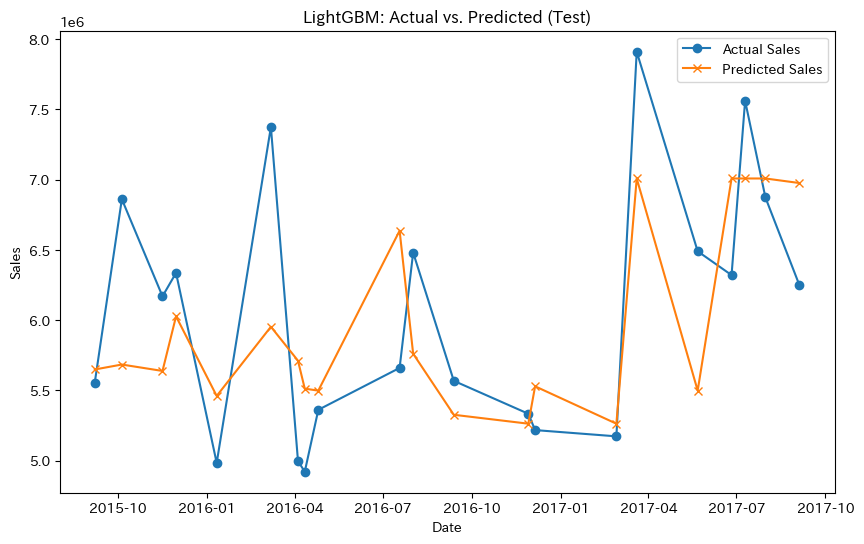

In [12]:
df_test = df_actual.loc[X_test.index].copy()
df_test["Predicted"] = y_test_pred
df_test.sort_values("Date", inplace=True)

plt.figure(figsize=(10,6))
plt.plot(df_test["Date"], df_test["Sales"], label="Actual Sales", marker='o')
plt.plot(df_test["Date"], df_test["Predicted"], label="Predicted Sales", marker='x')
plt.title("LightGBM: Actual vs. Predicted (Test)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

# Forecast Using LightGBM


Forecast Results:


,Date,Forecast_Sales
105,2017-09-11,5.791640e+06
106,2017-09-18,5.717629e+06
107,2017-09-25,5.648651e+06
108,2017-10-02,5.648651e+06
109,2017-10-09,5.648651e+06
110,2017-10-16,5.616315e+06
111,2017-10-23,5.385204e+06
112,2017-10-30,5.753901e+06
113,2017-11-06,5.564298e+06
114,2017-11-13,5.673555e+06


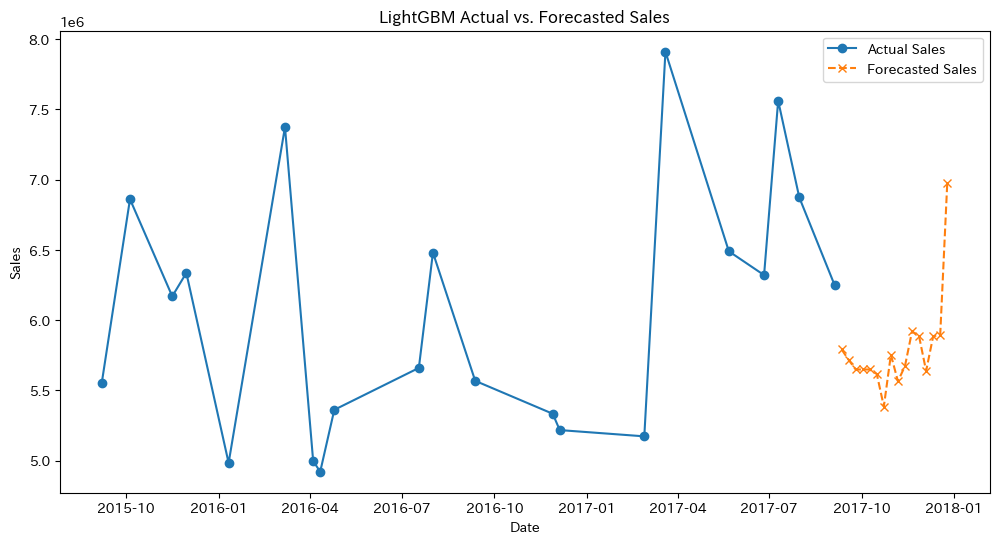

In [13]:
if len(df_forecast) > 0:
    X_forecast = df_forecast[predictor_cols].copy()
    df_forecast['Forecast_Sales'] = lgbm_model.predict(X_forecast)
    print("\nForecast Results:")
    display(df_forecast[['Date','Forecast_Sales']].sort_values('Date'))
    
    df_combined = pd.concat([df_test, df_forecast], ignore_index=True)
    df_combined.sort_values('Date', inplace=True)

    plt.figure(figsize=(12,6))
    plt.plot(df_test['Date'], df_test['Sales'], label='Actual Sales', marker='o')
    plt.plot(df_forecast['Date'], df_forecast['Forecast_Sales'], label='Forecasted Sales', marker='x', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title('LightGBM Actual vs. Forecasted Sales')
    plt.legend()
    plt.show()
else:
    print("No forecast rows found.")